In [ ]:
%matplotlib inline

import pandas as pd

In [ ]:
input = pd.read_csv('input/train.csv', index_col=0)
input[:5]

In [ ]:
print('Passenger numbers are between: ' + str(input['passenger_count'].min()) + '-' + str(input['passenger_count'].max()))
input['passenger_count'].hist()

In [ ]:
print('Trip duration spread: ' + str(input['trip_duration'].min()) + ' - ' + "{:,}".format(input['trip_duration'].max()))
input['trip_duration'][input['trip_duration']<6000].hist(bins=30, figsize=(15,5))

https://www.kaggle.com/maheshdadhich/strength-of-visualization-python-visuals-tutorial

In [ ]:
import os
import pandas as pd
import numpy as np
from matplotlib.pyplot import *
import matplotlib.pyplot as plt
from matplotlib import animation
from matplotlib import cm
from sklearn.cluster import KMeans
from sklearn.neighbors import KNeighborsClassifier
from dateutil import parser
import io
import base64
from IPython.display import HTML
from imblearn.under_sampling import RandomUnderSampler
from subprocess import check_output

In [ ]:
df = pd.read_csv('input/train.csv')
df[:5]

In [ ]:
print('Pickup longitude [' + str(df.pickup_longitude.min()) + ', ' + str(df.pickup_longitude.max()) + ']')
print('Pickup latitude [' + str(df.pickup_latitude.min()) + ', ' + str(df.pickup_latitude.max()) + ']')
print('Dropoff longitude [' + str(df.dropoff_longitude.min()) + ', ' + str(df.dropoff_longitude.max()) + ']')
print('Dropoff latitude [' + str(df.dropoff_latitude.min()) + ', ' + str(df.dropoff_latitude.max()) + ']')

In [ ]:
xlim = [-74.03, -73.77]
ylim = [40.63, 40.85]
df = df[(df.pickup_longitude> xlim[0]) & (df.pickup_longitude < xlim[1])]
df = df[(df.dropoff_longitude> xlim[0]) & (df.dropoff_longitude < xlim[1])]
df = df[(df.pickup_latitude> ylim[0]) & (df.pickup_latitude < ylim[1])]
df = df[(df.dropoff_latitude> ylim[0]) & (df.dropoff_latitude < ylim[1])]

In [ ]:
longitude = list(df.pickup_longitude) + list(df.dropoff_longitude)
latitude = list(df.pickup_latitude) + list(df.dropoff_latitude)
plt.figure(figsize = (10,10))
plt.plot(longitude, latitude, '.', alpha = 0.4, markersize = 0.05)
plt.show()

In [ ]:
loc_df = pd.DataFrame()
loc_df['longitude'] = longitude
loc_df['latitude'] = latitude

In [ ]:
kmeans = KMeans(n_clusters=15, random_state=2, n_init = 10).fit(loc_df)
loc_df['label'] = kmeans.labels_

loc_df = loc_df.sample(200000)
plt.figure(figsize = (10, 10))
for label in loc_df.label.unique():
    plt.plot(loc_df.longitude[loc_df.label == label], loc_df.latitude[loc_df.label == label], '.', alpha = 0.3, markersize = 0.3)

plt.title('Clusters of New York')
plt.show()

In [ ]:
fig,ax = plt.subplots(figsize = (10,10))
for label in loc_df.label.unique():
    ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 0.4, markersize = 0.1, color = 'gray')
    ax.plot(kmeans.cluster_centers_[label,0], kmeans.cluster_centers_[label,1], 'o', color = 'r')
    ax.annotate(label, (kmeans.cluster_centers_[label, 0],kmeans.cluster_centers_[label, 1]), color = 'b', fontsize = 20)
ax.set_title('Cluster Centers')
plt.show()

In [ ]:
df['pickup_cluster'] = kmeans.predict(df[['pickup_longitude', 'pickup_latitude']])
df['dropoff_cluster'] = kmeans.predict(df[['dropoff_longitude', 'dropoff_latitude']])
df['pickup_hour'] = df.pickup_datetime.apply(lambda x: parser.parse(x).hour )

In [ ]:
clusters = pd.DataFrame()
clusters['x'] = kmeans.cluster_centers_[:, 0]
clusters['y'] = kmeans.cluster_centers_[:, 1]
clusters['label'] = range(len(clusters))

In [ ]:
loc_df = loc_df.sample(5000)

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10, 10))

def animate(hour):
    ax.clear()
    ax.set_title('Absolute Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10));
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray');
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r');


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = 15*pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation.mp4', writer='ffmpeg', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

In [ ]:
fig, ax = plt.subplots(1, 1, figsize = (10,10))

def animate(hour):
    ax.clear()
    ax.set_title('Relative Traffic - Hour ' + str(int(hour)) + ':00')    
    plt.figure(figsize = (10,10))
    for label in loc_df.label.unique():
        ax.plot(loc_df.longitude[loc_df.label == label],loc_df.latitude[loc_df.label == label],'.', alpha = 1, markersize = 2, color = 'gray')
        ax.plot(kmeans.cluster_centers_[label,0],kmeans.cluster_centers_[label,1],'o', color = 'r')


    for label in clusters.label:
        for dest_label in clusters.label:
            num_of_rides = len(df[(df.pickup_cluster == label) & (df.dropoff_cluster == dest_label) & (df.pickup_hour == hour)])
            dist_x = clusters.x[clusters.label == label].values[0] - clusters.x[clusters.label == dest_label].values[0]
            dist_y = clusters.y[clusters.label == label].values[0] - clusters.y[clusters.label == dest_label].values[0]
            pct = np.true_divide(num_of_rides,len(df[df.pickup_hour == hour]))
            arr = Arrow(clusters.x[clusters.label == label].values, clusters.y[clusters.label == label].values, -dist_x, -dist_y, edgecolor='white', width = pct)
            ax.add_patch(arr)
            arr.set_facecolor('g')


ani = animation.FuncAnimation(fig,animate,sorted(df.pickup_hour.unique()), interval = 1000)
plt.close()
ani.save('animation.gif', writer='imagemagick', fps=2)
filename = 'animation.gif'
video = io.open(filename, 'r+b').read()
encoded = base64.b64encode(video)
HTML(data='''<img src="data:image/gif;base64,{0}" type="gif" />'''.format(encoded.decode('ascii')))

# NYCT - from A to Z with XGBoost (Tutorial)
https://www.kaggle.com/karelrv/nyct-from-a-to-z-with-xgboost-tutorial
### 1. Loading the data

In [1]:
%matplotlib inline
import pandas as pd
from datetime import datetime
import pandas as pd
from sklearn.model_selection import train_test_split
import xgboost as xgb
from sklearn.linear_model import LinearRegression, Ridge,BayesianRidge
from sklearn.cluster import MiniBatchKMeans
from sklearn.metrics import mean_squared_error
from math import radians, cos, sin, asin, sqrt
import seaborn as sns
import matplotlib
import numpy as np
import matplotlib.pyplot as plt
plt.rcParams['figure.figsize'] = [16, 10]

In [2]:
train = pd.read_csv('input/train.csv')
test = pd.read_csv('input/test.csv')

In [3]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.head()

,id,vendor_id,pickup_datetime,dropoff_datetime,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,store_and_fwd_flag,trip_duration
0,id2875421,2,2016-03-14 17:24:55,2016-03-14 17:32:30,1,-73.982,40.768,-73.965,40.766,N,455
1,id2377394,1,2016-06-12 00:43:35,2016-06-12 00:54:38,1,-73.980,40.739,-73.999,40.731,N,663
2,id3858529,2,2016-01-19 11:35:24,2016-01-19 12:10:48,1,-73.979,40.764,-74.005,40.710,N,2124
3,id3504673,2,2016-04-06 19:32:31,2016-04-06 19:39:40,1,-74.010,40.720,-74.012,40.707,N,429
4,id2181028,2,2016-03-26 13:30:55,2016-03-26 13:38:10,1,-73.973,40.793,-73.973,40.783,N,435


In [4]:
pd.set_option('display.float_format', lambda x: '%.3f' % x)
train.describe()

,vendor_id,passenger_count,pickup_longitude,pickup_latitude,dropoff_longitude,dropoff_latitude,trip_duration
count,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000,1458644.000
mean,1.535,1.665,-73.973,40.751,-73.973,40.752,959.492
std,0.499,1.314,0.071,0.033,0.071,0.036,5237.432
min,1.000,0.000,-121.933,34.360,-121.933,32.181,1.000
25%,1.000,1.000,-73.992,40.737,-73.991,40.736,397.000
50%,2.000,1.000,-73.982,40.754,-73.980,40.755,662.000
75%,2.000,2.000,-73.967,40.768,-73.963,40.770,1075.000
max,2.000,9.000,-61.336,51.881,-61.336,43.921,3526282.000


In [5]:
train.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1458644 entries, 0 to 1458643
Data columns (total 11 columns):
id                    1458644 non-null object
vendor_id             1458644 non-null int64
pickup_datetime       1458644 non-null object
dropoff_datetime      1458644 non-null object
passenger_count       1458644 non-null int64
pickup_longitude      1458644 non-null float64
pickup_latitude       1458644 non-null float64
dropoff_longitude     1458644 non-null float64
dropoff_latitude      1458644 non-null float64
store_and_fwd_flag    1458644 non-null object
trip_duration         1458644 non-null int64
dtypes: float64(4), int64(3), object(4)
memory usage: 122.4+ MB


### 2. Data preparation

In [6]:
m = np.mean(train['trip_duration'])
s = np.std(train['trip_duration'])
train = train[train['trip_duration'] <= m + 2*s]
train = train[train['trip_duration'] >= m - 2*s]

In [7]:
print('Mean: ' + str(m) + ', standard deviation: ' + str(s) + ', count: ' + '{:,}'.format(train.shape[0]))

Mean: 959.4922729603659, standard deviation: 5237.429929188969, count: 1,456,540


In [8]:
train = train[train['pickup_longitude'] <= -73.75]
train = train[train['pickup_longitude'] >= -74.03]
train = train[train['pickup_latitude'] <= 40.85]
train = train[train['pickup_latitude'] >= 40.63]
train = train[train['dropoff_longitude'] <= -73.75]
train = train[train['dropoff_longitude'] >= -74.03]
train = train[train['dropoff_latitude'] <= 40.85]
train = train[train['dropoff_latitude'] >= 40.63]
print('Count: ' + '{:,}'.format(train.shape[0]))

Count: 1,437,128


In [10]:
train['pickup_datetime'] = pd.to_datetime(train.pickup_datetime)
test['pickup_datetime'] = pd.to_datetime(test.pickup_datetime)
train.loc[:, 'pickup_date'] = train['pickup_datetime'].dt.date
test.loc[:, 'pickup_date'] = test['pickup_datetime'].dt.date
train['dropoff_datetime'] = pd.to_datetime(train.dropoff_datetime) #Not in Test

### 3. Data visualization and analysis

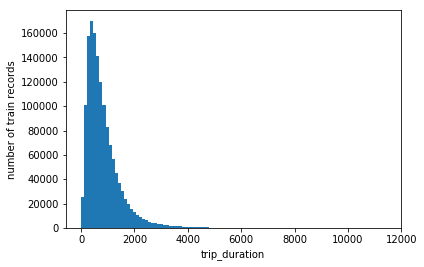

In [13]:
plt.hist(train['trip_duration'].values, bins=100)
plt.xlabel('trip_duration')
plt.ylabel('number of train records')
plt.show()

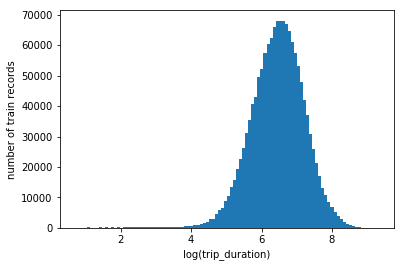

In [16]:
train['log_trip_duration'] = np.log(train['trip_duration'].values + 1)
plt.hist(train['log_trip_duration'].values, bins=100)
plt.xlabel('log(trip_duration)')
plt.ylabel('number of train records')
plt.show()

C:\ProgramData\Anaconda3\lib\site-packages\scipy\stats\stats.py:1713: FutureWarning: Using a non-tuple sequence for multidimensional indexing is deprecated; use `arr[tuple(seq)]` instead of `arr[seq]`. In the future this will be interpreted as an array index, `arr[np.array(seq)]`, which will result either in an error or a different result.
  return np.add.reduce(sorted[indexer] * weights, axis=axis) / sumval


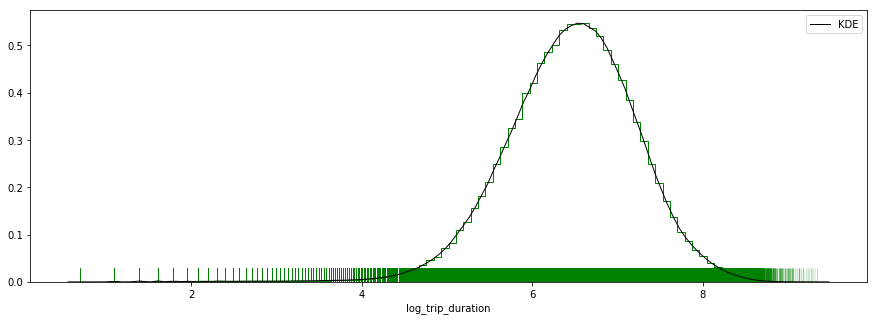

In [23]:
fig, ax = plt.subplots(figsize=(17, 5))

sns.distplot(train["log_trip_duration"], bins=100, rug=True, ax=ax,
                  rug_kws={"color": "g", "alpha": 0.1, "linewidth": 1},
                  kde_kws={"color": "k", "alpha": 1, "linewidth": 1, "label": "KDE"},
                  hist_kws={"color": "g", "alpha": 1, "linewidth": 1, "histtype": "step"})

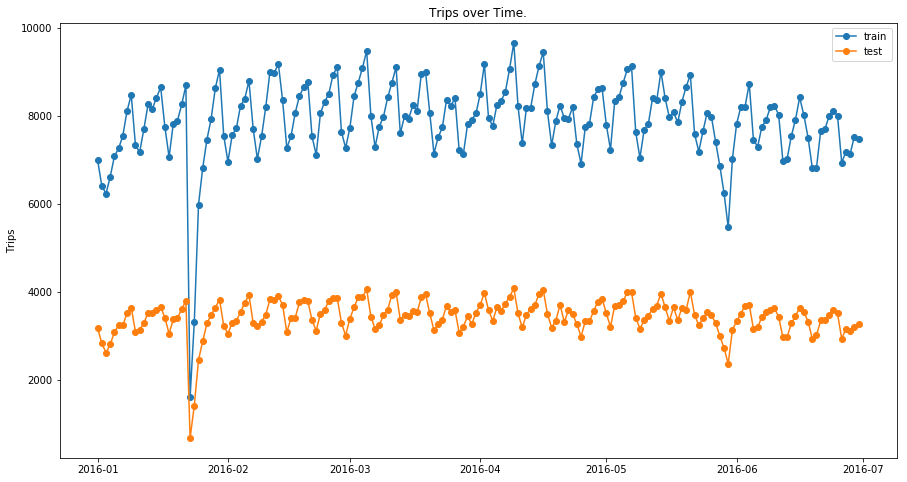

In [26]:
plt.figure(figsize=(17, 8))
plt.plot(train.groupby('pickup_date').count()[['id']], 'o-', label='train')
plt.plot(test.groupby('pickup_date').count()[['id']], 'o-', label='test')
plt.title('Trips over Time')
plt.legend(loc=0)
plt.ylabel('Trips')
plt.show()

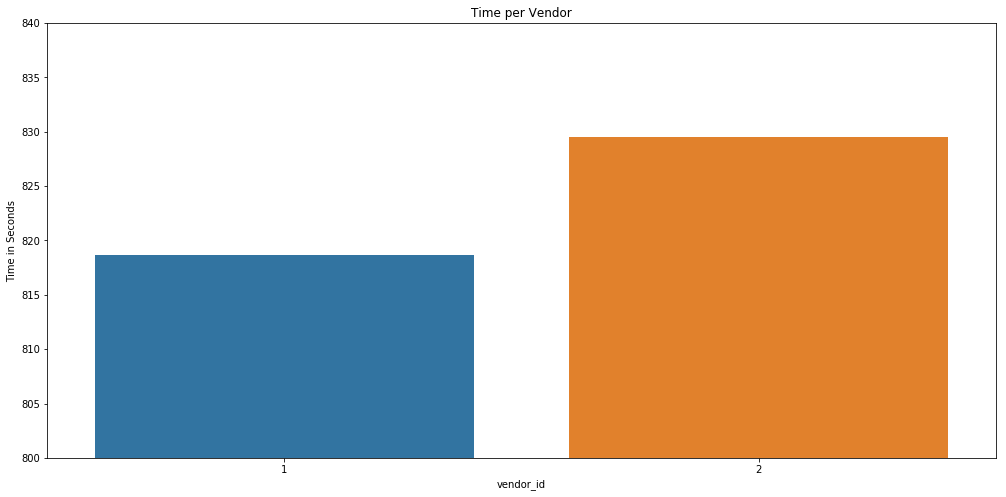

In [30]:
import warnings
warnings.filterwarnings("ignore")

plot_vendor = train.groupby('vendor_id')['trip_duration'].mean()
plt.subplots(1, 1, figsize=(17, 8))
plt.ylim(ymin=800)
plt.ylim(ymax=840)
plt.title('Time per Vendor')
plt.ylabel('Time in Seconds')
sns.barplot(plot_vendor.index, plot_vendor.values)

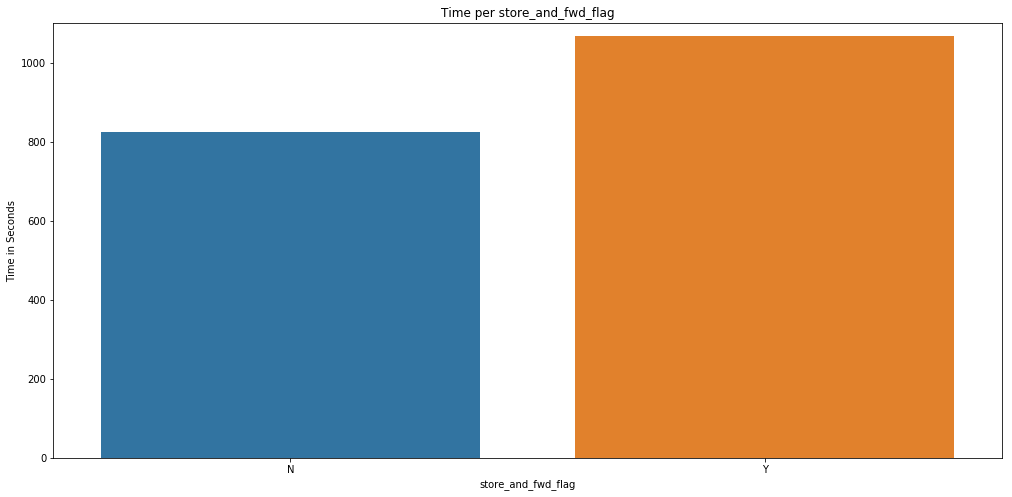

In [31]:
snwflag = train.groupby('store_and_fwd_flag')['trip_duration'].mean()

plt.subplots(1, 1, figsize=(17, 8))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.ylabel('Time in Seconds')
sns.barplot(snwflag.index, snwflag.values)

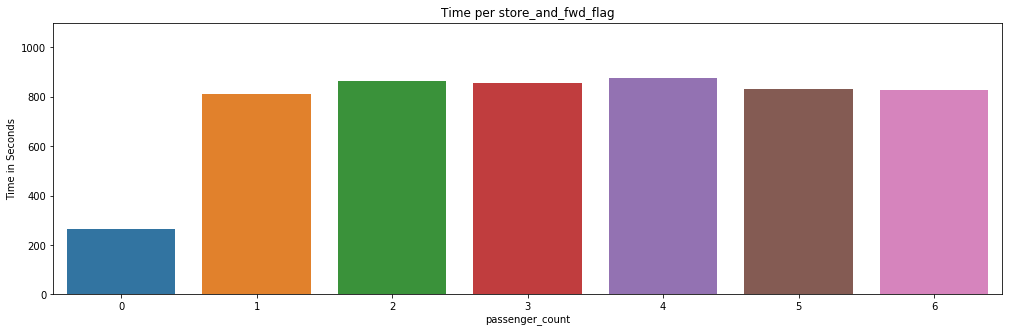

In [33]:
pc = train.groupby('passenger_count')['trip_duration'].mean()

plt.subplots(1, 1, figsize=(17, 5))
plt.ylim(ymin=0)
plt.ylim(ymax=1100)
plt.title('Time per store_and_fwd_flag')
plt.ylabel('Time in Seconds')
sns.barplot(pc.index, pc.values)

In [34]:
train.groupby('passenger_count').size()

passenger_count
0         52
1    1018715
2     206864
3      58989
4      27957
5      76912
6      47639
dtype: int64

In [35]:
test.groupby('passenger_count').size()

passenger_count
0        23
1    443447
2     90027
3     25686
4     12017
5     33411
6     20521
9         2
dtype: int64

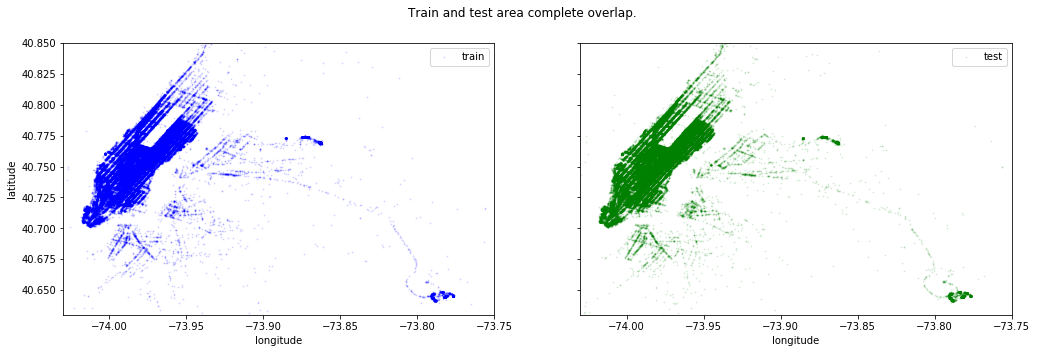

In [37]:
city_long_border = (-74.03, -73.75)
city_lat_border = (40.63, 40.85)
fig, ax = plt.subplots(ncols=2, sharex=True, sharey=True, figsize=(17, 5))
ax[0].scatter(train['pickup_longitude'].values[:100000], train['pickup_latitude'].values[:100000],
              color='blue', s=1, label='train', alpha=0.1)
ax[1].scatter(test['pickup_longitude'].values[:100000], test['pickup_latitude'].values[:100000],
              color='green', s=1, label='test', alpha=0.1)
fig.suptitle('Train and test area complete overlap.')
ax[0].legend(loc=0)
ax[0].set_ylabel('latitude')
ax[0].set_xlabel('longitude')
ax[1].legend(loc=0)
ax[1].set_xlabel('longitude')
plt.xlim(city_long_border)
plt.ylim(city_lat_border)
plt.show()

In [38]:
def haversine_array(lat1, lng1, lat2, lng2):
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    AVG_EARTH_RADIUS = 6371  # in km
    lat = lat2 - lat1
    lng = lng2 - lng1
    d = np.sin(lat * 0.5) ** 2 + np.cos(lat1) * np.cos(lat2) * np.sin(lng * 0.5) ** 2
    h = 2 * AVG_EARTH_RADIUS * np.arcsin(np.sqrt(d))
    return h

def dummy_manhattan_distance(lat1, lng1, lat2, lng2):
    a = haversine_array(lat1, lng1, lat1, lng2)
    b = haversine_array(lat1, lng1, lat2, lng1)
    return a + b

def bearing_array(lat1, lng1, lat2, lng2):
    AVG_EARTH_RADIUS = 6371  # in km
    lng_delta_rad = np.radians(lng2 - lng1)
    lat1, lng1, lat2, lng2 = map(np.radians, (lat1, lng1, lat2, lng2))
    y = np.sin(lng_delta_rad) * np.cos(lat2)
    x = np.cos(lat1) * np.sin(lat2) - np.sin(lat1) * np.cos(lat2) * np.cos(lng_delta_rad)
    return np.degrees(np.arctan2(y, x))

In [39]:
train.loc[:, 'distance_haversine'] = haversine_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_haversine'] = haversine_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)    
    
train.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'distance_dummy_manhattan'] =  dummy_manhattan_distance(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

train.loc[:, 'direction'] = bearing_array(train['pickup_latitude'].values, train['pickup_longitude'].values, train['dropoff_latitude'].values, train['dropoff_longitude'].values)
test.loc[:, 'direction'] = bearing_array(test['pickup_latitude'].values, test['pickup_longitude'].values, test['dropoff_latitude'].values, test['dropoff_longitude'].values)

In [41]:
coords = np.vstack((train[['pickup_latitude', 'pickup_longitude']].values,
                    train[['dropoff_latitude', 'dropoff_longitude']].values))

In [44]:
sample_ind = np.random.permutation(len(coords))[:500000]
kmeans = MiniBatchKMeans(n_clusters=100, batch_size=10000).fit(coords[sample_ind])

In [48]:
train.loc[:, 'pickup_cluster'] = kmeans.predict(train[['pickup_latitude', 'pickup_longitude']])
train.loc[:, 'dropoff_cluster'] = kmeans.predict(train[['dropoff_latitude', 'dropoff_longitude']])
test.loc[:, 'pickup_cluster'] = kmeans.predict(test[['pickup_latitude', 'pickup_longitude']])
test.loc[:, 'dropoff_cluster'] = kmeans.predict(test[['dropoff_latitude', 'dropoff_longitude']])

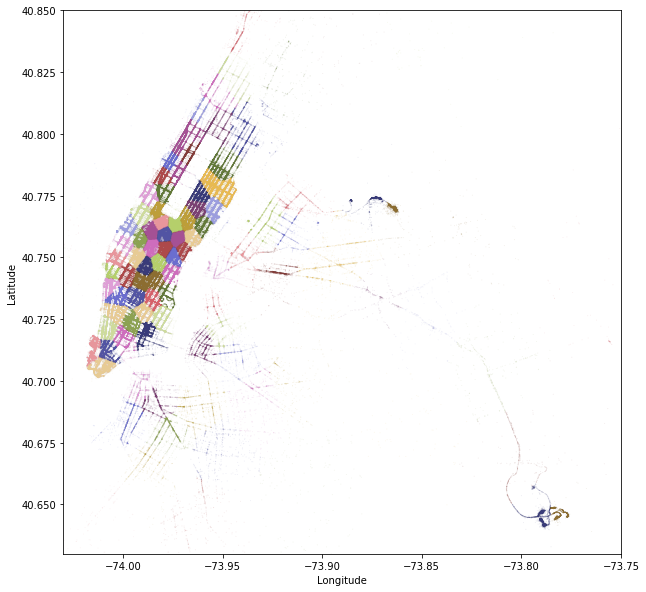

In [57]:
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.scatter(train.pickup_longitude.values[:1000000], train.pickup_latitude.values[:1000000], s=1, lw=0,
           c=train.pickup_cluster[:1000000].values, cmap='tab20b', alpha=0.1)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.show()

In [58]:
train['Month'] = train['pickup_datetime'].dt.month
test['Month'] = test['pickup_datetime'].dt.month

In [59]:
train.groupby('Month').size(), test.groupby('Month').size()

(Month
 1    226444
 2    235054
 3    252443
 4    247855
 5    244591
 6    230741
 dtype: int64, Month
 1     97676
 2    102314
 3    109697
 4    107432
 5    107570
 6    100445
 dtype: int64)

In [60]:
train['DayofMonth'] = train['pickup_datetime'].dt.day
test['DayofMonth'] = test['pickup_datetime'].dt.day
len(train.groupby('DayofMonth').size()), len(test.groupby('DayofMonth').size())

(31, 31)

In [61]:
train['Hour'] = train['pickup_datetime'].dt.hour
test['Hour'] = test['pickup_datetime'].dt.hour
len(train.groupby('Hour').size()), len(test.groupby('Hour').size())

(24, 24)

In [62]:
train['dayofweek'] = train['pickup_datetime'].dt.dayofweek
test['dayofweek'] = test['pickup_datetime'].dt.dayofweek
len(train.groupby('dayofweek').size()), len(test.groupby('dayofweek').size())

(7, 7)

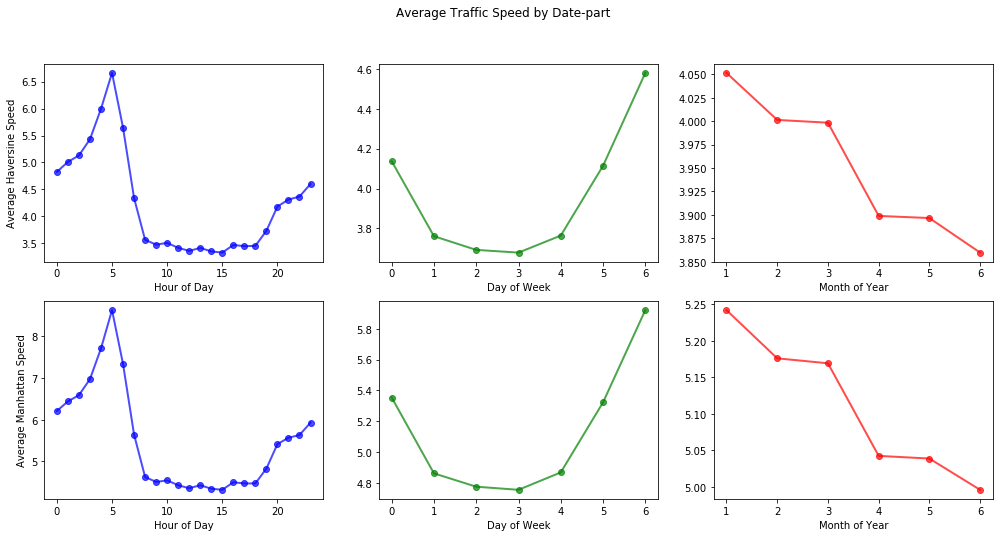

In [72]:
train.loc[:, 'avg_speed_h'] = 1000 * train['distance_haversine'] / train['trip_duration']
train.loc[:, 'avg_speed_m'] = 1000 * train['distance_dummy_manhattan'] / train['trip_duration']
fig, ax = plt.subplots(nrows=2, ncols=3, sharey=False, figsize=(17, 8))
ax[0][0].set_xlabel('Hour of Day')
ax[0][0].set_ylabel('Average Haversine Speed')
ax[0][0].plot(train.groupby('Hour').mean()['avg_speed_h'], 'bo-', lw=2, alpha=0.7)

ax[0][1].set_xlabel('Day of Week')
ax[0][1].plot(train.groupby('dayofweek').mean()['avg_speed_h'], 'go-', lw=2, alpha=0.7)

ax[0][2].set_xlabel('Month of Year')
ax[0][2].plot(train.groupby('Month').mean()['avg_speed_h'], 'ro-', lw=2, alpha=0.7)

# 2nd row
ax[1][0].set_xlabel('Hour of Day')
ax[1][0].set_ylabel('Average Manhattan Speed')
ax[1][0].plot(train.groupby('Hour').mean()['avg_speed_m'], 'bo-', lw=2, alpha=0.7)

ax[1][1].set_xlabel('Day of Week')
ax[1][1].plot(train.groupby('dayofweek').mean()['avg_speed_m'], 'go-', lw=2, alpha=0.7)

ax[1][2].set_xlabel('Month of Year')
ax[1][2].plot(train.groupby('Month').mean()['avg_speed_m'], 'ro-', lw=2, alpha=0.7)

fig.suptitle('Average Traffic Speed by Date-part')
plt.show()

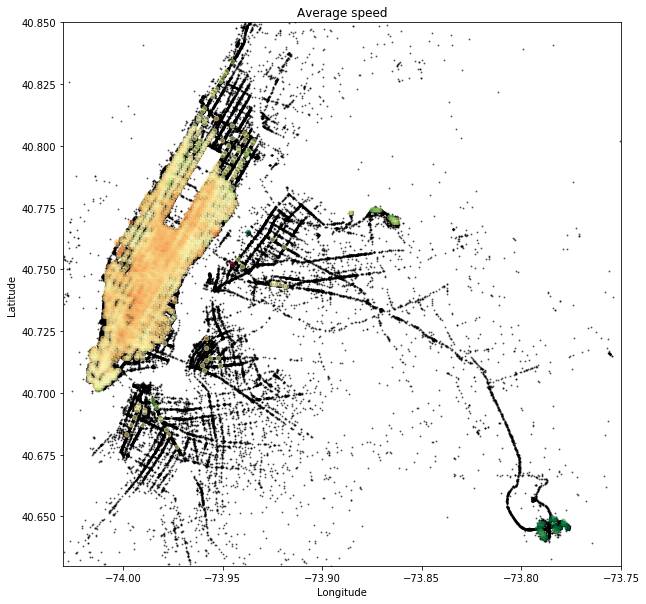

In [75]:
train.loc[:, 'pickup_lat_bin'] = np.round(train['pickup_latitude'], 3)
train.loc[:, 'pickup_long_bin'] = np.round(train['pickup_longitude'], 3)
# Average speed for regions
gby_cols = ['pickup_lat_bin', 'pickup_long_bin']
coord_speed = train.groupby(gby_cols).mean()[['avg_speed_h']].reset_index()
coord_count = train.groupby(gby_cols).count()[['id']].reset_index()
coord_stats = pd.merge(coord_speed, coord_count, on=gby_cols)
coord_stats = coord_stats[coord_stats['id'] > 100]
fig, ax = plt.subplots(ncols=1, nrows=1, figsize=(10, 10))
ax.scatter(train.pickup_longitude.values[:1000000], train.pickup_latitude.values[:1000000], color='black', s=1, alpha=0.5)
ax.scatter(coord_stats.pickup_long_bin.values, coord_stats.pickup_lat_bin.values, c=coord_stats.avg_speed_h.values,
           cmap='RdYlGn', s=20, alpha=0.5, vmin=1, vmax=8)
ax.set_xlim(city_long_border)
ax.set_ylim(city_lat_border)
ax.set_xlabel('Longitude')
ax.set_ylabel('Latitude')
plt.title('Average speed')
plt.show()

In [76]:
vendor_train = pd.get_dummies(train['vendor_id'], prefix='vi', prefix_sep='_')
vendor_test = pd.get_dummies(test['vendor_id'], prefix='vi', prefix_sep='_')
passenger_count_train = pd.get_dummies(train['passenger_count'], prefix='pc', prefix_sep='_')
passenger_count_test = pd.get_dummies(test['passenger_count'], prefix='pc', prefix_sep='_')
store_and_fwd_flag_train = pd.get_dummies(train['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
store_and_fwd_flag_test = pd.get_dummies(test['store_and_fwd_flag'], prefix='sf', prefix_sep='_')
cluster_pickup_train = pd.get_dummies(train['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_pickup_test = pd.get_dummies(test['pickup_cluster'], prefix='p', prefix_sep='_')
cluster_dropoff_train = pd.get_dummies(train['dropoff_cluster'], prefix='d', prefix_sep='_')
cluster_dropoff_test = pd.get_dummies(test['dropoff_cluster'], prefix='d', prefix_sep='_')

month_train = pd.get_dummies(train['Month'], prefix='m', prefix_sep='_')
month_test = pd.get_dummies(test['Month'], prefix='m', prefix_sep='_')
dom_train = pd.get_dummies(train['DayofMonth'], prefix='dom', prefix_sep='_')
dom_test = pd.get_dummies(test['DayofMonth'], prefix='dom', prefix_sep='_')
hour_train = pd.get_dummies(train['Hour'], prefix='h', prefix_sep='_')
hour_test = pd.get_dummies(test['Hour'], prefix='h', prefix_sep='_')
dow_train = pd.get_dummies(train['dayofweek'], prefix='dow', prefix_sep='_')
dow_test = pd.get_dummies(test['dayofweek'], prefix='dow', prefix_sep='_')

In [77]:
vendor_train.shape, vendor_test.shape

((1437128, 2), (625134, 2))

In [78]:
passenger_count_train.shape, passenger_count_test.shape

((1437128, 7), (625134, 8))

In [79]:
store_and_fwd_flag_train.shape, store_and_fwd_flag_test.shape

((1437128, 2), (625134, 2))

In [80]:
cluster_pickup_train.shape, cluster_pickup_test.shape

((1437128, 100), (625134, 100))

In [81]:
cluster_dropoff_train.shape, cluster_dropoff_test.shape

((1437128, 100), (625134, 100))

In [82]:
month_train.shape, month_test.shape

((1437128, 6), (625134, 6))

In [83]:
dom_train.shape, dom_test.shape

((1437128, 31), (625134, 31))

In [84]:
hour_train.shape, hour_test.shape

((1437128, 24), (625134, 24))

In [85]:
dow_train.shape, dow_test.shape

((1437128, 7), (625134, 7))

In [87]:
passenger_count_test = passenger_count_test.drop('pc_9', axis = 1)

In [88]:
train = train.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek', 'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'],axis = 1)
Test_id = test['id']
test = test.drop(['id','vendor_id','passenger_count','store_and_fwd_flag','Month','DayofMonth','Hour','dayofweek', 'pickup_longitude','pickup_latitude','dropoff_longitude','dropoff_latitude'], axis = 1)
train = train.drop(['dropoff_datetime','avg_speed_h','avg_speed_m','pickup_lat_bin','pickup_long_bin','trip_duration'], axis = 1)

In [89]:
train.shape, test.shape

((1437128, 8), (625134, 7))

In [91]:
Train_Master = pd.concat([train, vendor_train, passenger_count_train, store_and_fwd_flag_train, cluster_pickup_train, cluster_dropoff_train, month_train, dom_train, hour_test, dow_train], axis=1)
Test_master = pd.concat([test, vendor_test, passenger_count_test, store_and_fwd_flag_test, cluster_pickup_test, cluster_dropoff_test, month_test, dom_test, hour_test, dow_test], axis=1)

In [92]:
Train_Master.shape, Test_master.shape

((1446345, 287), (625134, 286))

In [94]:
Train_Master = Train_Master.drop(['pickup_datetime','pickup_date'], axis = 1)
Test_master = Test_master.drop(['pickup_datetime','pickup_date'], axis = 1)

In [95]:
Train_Master.shape, Test_master.shape

((1446345, 285), (625134, 284))

In [96]:
Train, Test = train_test_split(Train_Master[0:100000], test_size = 0.2)

In [99]:
X_train = Train.drop(['log_trip_duration'], axis=1)
Y_train = Train["log_trip_duration"]
X_test = Test.drop(['log_trip_duration'], axis=1)
Y_test = Test["log_trip_duration"]

Y_test = Y_test.reset_index().drop('index',axis = 1)
Y_train = Y_train.reset_index().drop('index',axis = 1)

In [100]:
dtrain = xgb.DMatrix(X_train, label=Y_train)
dvalid = xgb.DMatrix(X_test, label=Y_test)
dtest = xgb.DMatrix(Test_master)
watchlist = [(dtrain, 'train'), (dvalid, 'valid')]

### 4. XGBoost

In [104]:
xgb_pars = {
    'min_child_weight': 1,
    'eta': 0.5,
    'colsample_bytree': 0.9,
    'max_depth': 6,
    'subsample': 0.9,
    'lambda': 1.,
    'nthread': -1,
    'booster': 'gbtree',
    'silent': 1,
    'eval_metric': 'rmse',
    'objective': 'reg:linear'
}
model = xgb.train(xgb_pars, dtrain, 10, watchlist, early_stopping_rounds=2, maximize=False, verbose_eval=1)
print('Modeling RMSLE %.5f' % model.best_score)

[0]	train-rmse:nan	valid-rmse:nan
Multiple eval metrics have been passed: 'valid-rmse' will be used for early stopping.

Will train until valid-rmse hasn't improved in 2 rounds.
[1]	train-rmse:nan	valid-rmse:nan
[2]	train-rmse:nan	valid-rmse:nan


KeyError: 'best_msg'

In [ ]:
xgb.plot_importance(model, max_num_features=28, height=0.7)

In [ ]:
pred = model.predict(dtest)
pred = np.exp(pred) - 1

In [ ]:
submission = pd.concat([Test_id, pd.DataFrame(pred)], axis=1)
submission.columns = ['id','trip_duration']
submission['trip_duration'] = submission.apply(lambda x : 1 if (x['trip_duration'] <= 0) else x['trip_duration'], axis = 1)
submission.to_csv("submission.csv", index=False)